<a href="https://colab.research.google.com/github/lonerpatti/BigDataPos/blob/main/Uni_Facef_DS_Gradient_Boosting_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='blue'>Uni-Facef - Data Science - Parte 1 </font>

    Neste notebook vamos criar um modelo de classificação usando o algorítmo Gradient Boosting. Vamos fazer o treinamento do modelo, medir sua acurácia (nível de acerto) e fazer a persistência (serialização do objeto em arquivo)

    Vamos utilizar a biblioteca Pandas e Scikit Learn.

### GRADIENT BOOSTING

    Trata-se de um Método Ensemble, onde ocorre a predição de múltiplos algoritmos base de árvore de regressão em um único classificador. Esse algoritmo implementa as seguintes técnicas:


#### Boosting
	
    Realiza a classificação a partir de um sistema de peso, constituído a partir do resultado de classificação de cada algoritmo base.

#### Gradient Descent
	
    Otimização iterativa para encontrar o mínimo de uma função de custo, a Cost function.


## Lendo o dataset em Dataframe Pandas 

In [2]:
from google.colab import files
uploaded = files.upload()

Saving gradient_boosting_training.csv to gradient_boosting_training.csv


In [3]:
import pandas as pd

# Lendo o dataset em csv e criando um Dataframe Pandas
df = pd.read_csv("gradient_boosting_training.csv", delimiter="|")

df.head(20)

,id,idade,uf,estadocivil,clienteespecial,dtprimeiracompra,ultimomeiopagto,ultimasparcelas,recencia,scorecompra,perfilcompra,qtdcompratotal,vlrcomprastotal,vlrmediocompra,propenso
0,1002442,39.0,19,3,0,124,3,1,123.0,0.0,1,1,298.00,298.00,0
1,10171031,43.0,18,6,0,133,1,1,1.0,20.5,3,7,21782.17,3111.74,0
2,1022507,32.0,11,3,0,99,1,10,10.0,13.0,3,6,5661.81,943.64,0
3,10226642,45.0,5,0,0,80,1,10,2.0,22.0,1,6,7251.12,1208.52,1
4,1024757,72.0,26,3,1,162,1,2,3.0,21.0,1,23,8507.38,369.89,1
5,1026193,33.0,11,0,0,41,1,12,1.0,23.5,2,8,5449.84,681.23,0
6,1027338,29.0,15,3,0,93,5,1,0.0,25.0,3,51,32747.07,642.10,1
7,1027644,26.0,18,0,0,63,1,4,10.0,12.0,2,11,9115.45,828.68,0
8,1028542,54.0,26,3,1,159,4,2,103.0,0.0,1,10,3413.20,341.32,0
9,10296663,60.0,16,0,0,28,1,10,8.0,13.0,1,5,4161.70,832.34,1


## Verificando a distribuição entre as classes (variável target)

É importante termos as classes bem balanceadas para que o algorítmo aprenda a relação desses dados de forma mais assertiva

In [4]:
print(df.groupby('propenso').size())

propenso
0    98705
1    78649
dtype: int64


## Fazendo um pré-processamento dos dados

Em sua grande maioria das vezes o trabalho de pré-processamento é pesado, pois podem haver muitos campos nulos, com ruídos (outliers), variáveis categóricas da qual muitos algorítimos não trabalham, etc. E há muitas técnicas para que cada caso possa ser tratado.

Nesse exemplo, consideramos que fizemos um trabalho de processamento e padronização previamente pelo Spark teremos um menor esforço de tratamento.

In [5]:
import numpy as np

# Tratando dados missing no vlrmediocompra
df['vlrmediocompra'] = df['vlrmediocompra'].replace(np.NaN, 0)

# Vamos usar a técnica de colocar média da massa para a idade
df['idade'].fillna(df['idade'].mean(), inplace=True)

# Vamos usar a média da massa para a recencia também
df['recencia'].fillna(df['recencia'].mean(), inplace=True)

## Separando a variável target (resposta) das variáveis preditoras

- X - Variáveis preditoras
- Y - Variável target ou resposta

In [6]:
cols = [col for col in df.columns if col not in ['id','propenso', 'recencia', 'scorecompra']]
print(cols)

['idade', 'uf', 'estadocivil', 'clienteespecial', 'dtprimeiracompra', 'ultimomeiopagto', 'ultimasparcelas', 'perfilcompra', 'qtdcompratotal', 'vlrcomprastotal', 'vlrmediocompra']


In [7]:
"""
Arrays:
 - X - Variáveis preditoras
 - Y - Variável target ou resposta
"""
X = df[cols].values
Y = df.propenso.values

## Colocando os valores das variável preditoras numa mesma escala

Observe que os valores numéricos não estão no mesma escala e muitos algorítimos terão melhor performance fazendo essa normalização

In [8]:
df.head(5)

,id,idade,uf,estadocivil,clienteespecial,dtprimeiracompra,ultimomeiopagto,ultimasparcelas,recencia,scorecompra,perfilcompra,qtdcompratotal,vlrcomprastotal,vlrmediocompra,propenso
0,1002442,39.0,19,3,0,124,3,1,123.0,0.0,1,1,298.00,298.00,0
1,10171031,43.0,18,6,0,133,1,1,1.0,20.5,3,7,21782.17,3111.74,0
2,1022507,32.0,11,3,0,99,1,10,10.0,13.0,3,6,5661.81,943.64,0
3,10226642,45.0,5,0,0,80,1,10,2.0,22.0,1,6,7251.12,1208.52,1
4,1024757,72.0,26,3,1,162,1,2,3.0,21.0,1,23,8507.38,369.89,1


#### Para isso usaremos o método "scale" do módulo "preprocessing" do "sklearn"

In [9]:
from sklearn.preprocessing import scale

X = scale(X)

print(X)

[[-2.40943265e-01  2.49437089e-02  8.09851890e-02 ... -6.90280723e-01
  -7.16955368e-01 -8.87970778e-01]
 [-1.22410063e-01 -1.10235248e-01  1.36811192e+00 ... -2.94298482e-01
   1.09902248e+00  3.90641572e+00]
 [-4.48376368e-01 -1.05648795e+00  8.09851890e-02 ... -3.60295522e-01
  -2.63572243e-01  2.12147819e-01]
 ...
 [-3.87686045e-03 -3.80593163e-01 -1.20614154e+00 ... -6.90280723e-01
  -7.35551159e-01 -1.26283307e+00]
 [ 2.57564401e-02 -1.10235248e-01 -1.20614154e+00 ... -6.90280723e-01
  -7.32913938e-01 -1.20967078e+00]
 [-9.27767620e-02  9.71196410e-01 -3.48057055e-01 ... -3.60295522e-01
  -1.98805640e-01  4.29738341e-01]]


## Separando os dados de treino dos dados de teste

Para isso usaremos o método "train_test_split" do módulo "model_selection" do "sklearn"

In [10]:
from sklearn.model_selection import train_test_split

# Percentual da massa para treino
validation_size = 0.30

"""
Retorna 4 arrays diferentes:

X_Train - Variáveis preditoras para o treinamento do modelo
X_Test - Variáveis preditoras para o teste do modelo

Y_Train - Variável target ou resposta para treinamento do modelo
Y_Test - Variável target ou resposta usada para validação do modelo
"""

X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size = validation_size)

In [11]:
Y_Train

array([1, 0, 0, ..., 0, 0, 0])

## Criando uma instancia do algoritmo Classificador

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

In [12]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(
    n_estimators=50,
    learning_rate=1, 
    min_samples_split=3, 
    min_samples_leaf=2)

print(clf)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=2, min_samples_split=3,
                           min_weight_fraction_leaf=0.0, n_estimators=50,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


## Treinamento e persistência do modelo

Treina o modelo através do método "fit" do Classificador

In [13]:
model = clf.fit(X_Train, Y_Train)

#### Persistirá o modelo treinado em arquivo

Para isso usaremos o módulo "pickle" que fará a serialização do objeto

In [14]:
import pickle

pickle.dump(model, open("gradient_boosting_model_pickle.dat", "wb"))

## Fazendo a predição da variável resposta esperada

Podemos utilizar o modelo em memória ou fazer o "load" do modelo persistido

In [15]:
model_serial = pickle.load(open("gradient_boosting_model_pickle.dat", "rb"))

model_serial

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=2, min_samples_split=3,
                           min_weight_fraction_leaf=0.0, n_estimators=50,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

#### Fazendo previsão com variaveis preditoras de teste através do método "predict" do classificador

In [16]:
prediction = model.predict(X_Test)

prediction

array([0, 1, 0, ..., 1, 0, 1])

In [17]:
score = model.predict_proba(X_Test)[:,1]

score

array([8.40320712e-04, 9.43358093e-01, 2.26103913e-01, ...,
       9.50626517e-01, 6.71001736e-02, 9.30168691e-01])

In [18]:
df_predict = pd.DataFrame(prediction, columns=['propenso'])
df_score = pd.DataFrame(score, columns=['score'])

df_result = pd.merge(df_predict, df_score, how = 'left', left_index = True, right_index = True)

df_result.head(10)

,propenso,score
0,0,0.000840
1,1,0.943358
2,0,0.226104
3,1,0.984232
4,1,0.670875
5,0,0.002161
6,1,0.750763
7,1,0.957439
8,0,0.053512
9,0,0.010348


## Avaliando o modelo

In [19]:
from sklearn.metrics import accuracy_score

print (accuracy_score(Y_Test, prediction))

0.7885428609017611


In [20]:
from sklearn.metrics import confusion_matrix

print ("Confusion Matrix:\n")
print (confusion_matrix(Y_Test, prediction))

Confusion Matrix:

[[23960  5693]
 [ 5558 17996]]


In [21]:
from sklearn.metrics import classification_report

print ("Classification Report:\n")
print (classification_report(Y_Test, prediction))

Classification Report:

              precision    recall  f1-score   support

           0       0.81      0.81      0.81     29653
           1       0.76      0.76      0.76     23554

    accuracy                           0.79     53207
   macro avg       0.79      0.79      0.79     53207
weighted avg       0.79      0.79      0.79     53207



### Relevância das principais variáveis preditoras para o Modelo 

In [22]:
model.feature_importances_

array([0.00705197, 0.02610102, 0.03392351, 0.01223576, 0.15549681,
       0.01583527, 0.03708251, 0.15067824, 0.23475448, 0.32153762,
       0.00530281])

In [23]:
cols

['idade',
 'uf',
 'estadocivil',
 'clienteespecial',
 'dtprimeiracompra',
 'ultimomeiopagto',
 'ultimasparcelas',
 'perfilcompra',
 'qtdcompratotal',
 'vlrcomprastotal',
 'vlrmediocompra']

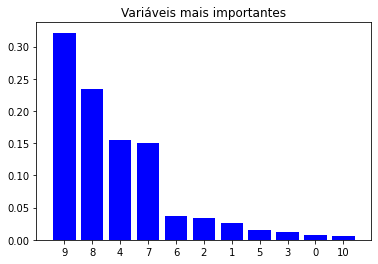

0 - idade --> 0.007051969942831967
1 - uf --> 0.026101016040408386
2 - estadocivil --> 0.03392351021374655
3 - clienteespecial --> 0.012235759700559071
4 - dtprimeiracompra --> 0.15549681317825612
5 - ultimomeiopagto --> 0.015835274285440293
6 - ultimasparcelas --> 0.03708251269883281
7 - perfilcompra --> 0.15067823904088587
8 - qtdcompratotal --> 0.2347544775703878
9 - vlrcomprastotal --> 0.3215376210724083
10 - vlrmediocompra --> 0.005302806256242765


In [24]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Variáveis mais importantes")

plt.bar(range(X.shape[1]), importances[indices], color="b", align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])

plt.show()

# Mostrar legenda abaixo do gráfico
for i in range(0,len(cols)):
    print (str(i)+' - '+ cols[i] +' --> '+ str(model.feature_importances_[i]))

### Verificando a correlação entre as variáveis

In [25]:
df.corr()

,id,idade,uf,estadocivil,clienteespecial,dtprimeiracompra,ultimomeiopagto,ultimasparcelas,recencia,scorecompra,perfilcompra,qtdcompratotal,vlrcomprastotal,vlrmediocompra,propenso
id,1.000000,0.067596,-0.057365,0.019272,0.022666,0.033765,0.002980,0.004257,0.033586,-0.049745,-0.050499,-0.022259,-0.005139,0.023414,-0.031651
idade,0.067596,1.000000,0.022161,0.079032,0.083755,0.101954,0.024166,0.012721,0.074911,-0.079060,-0.114754,0.007187,0.018520,0.012819,-0.022520
uf,-0.057365,0.022161,1.000000,0.186844,0.080116,0.233197,0.019041,-0.006379,0.081532,-0.085716,0.033725,0.052920,0.029456,-0.037439,-0.085689
estadocivil,0.019272,0.079032,0.186844,1.000000,0.212235,0.354504,0.054906,0.017050,0.113378,-0.084815,-0.063833,0.104941,0.080455,-0.029159,-0.028464
clienteespecial,0.022666,0.083755,0.080116,0.212235,1.000000,0.424617,-0.006028,0.127740,-0.041646,0.080533,-0.077232,0.379221,0.354429,-0.024843,0.138516
dtprimeiracompra,0.033765,0.101954,0.233197,0.354504,0.424617,1.000000,0.037256,0.048138,0.166454,-0.045881,0.085115,0.335001,0.271489,-0.096637,-0.027995
ultimomeiopagto,0.002980,0.024166,0.019041,0.054906,-0.006028,0.037256,1.000000,-0.395491,0.092745,-0.072753,-0.133066,-0.010252,-0.033604,-0.035482,0.010780
ultimasparcelas,0.004257,0.012721,-0.006379,0.017050,0.127740,0.048138,-0.395491,1.000000,-0.114189,0.172284,-0.062292,0.086549,0.174947,0.243173,0.204241
recencia,0.033586,0.074911,0.081532,0.113378,-0.041646,0.166454,0.092745,-0.114189,1.000000,-0.721957,-0.203408,-0.271808,-0.274626,-0.062025,-0.485610
scorecompra,-0.049745,-0.079060,-0.085716,-0.084815,0.080533,-0.045881,-0.072753,0.172284,-0.721957,1.000000,0.256742,0.396501,0.401892,0.092800,0.660571


#### Aprenda mais sobre "scikit-learn": 

https://scikit-learn.org/stable/